In [13]:
import os
from ultralytics import YOLO
import torchvision
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import sys
import os
# Get project root (assuming notebook is in scripts/jupyter_nb/)
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

from xai.drise_batch import DRISEBatch
from utils.utils import load_and_convert_bboxes
from utils.plot_utils import plot_image_with_bboxes, plot_saliency_and_targetbb_on_image

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [14]:
class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
args = Args(**{
    'img_name': '00901',
    'model_path': 'use_case/models/best.pt',
    'datadir': 'use_case/',
    'annotations_dir': 'use_case/',
    'device': 'cuda:0',
    'input_size': (480, 640),
    'gpu_batch': 16,
    'mask_type': 'close',
    'maskdir': 'masks/',
    'N': 1000,
    'resolution': 8,
    'p1': 0.25,
    'target_classes': [0],
})

args.datadir = os.path.join(project_root, args.datadir)
args.annotations_dir = os.path.join(project_root, args.annotations_dir)
args.maskdir = os.path.join(project_root, args.maskdir)
args.model_path = os.path.join(project_root, args.model_path)

## Data Processing

(480, 640, 3)
(480, 640, 3) uint8


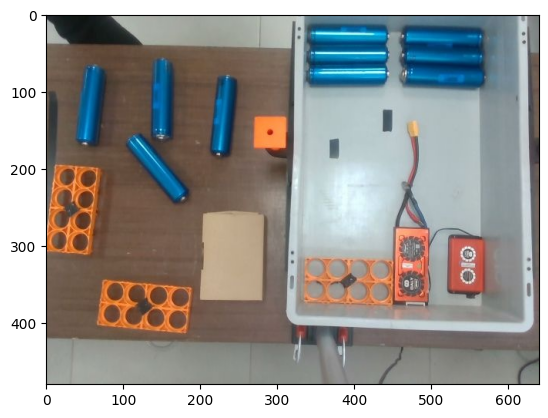

In [15]:
#########################
# Import data
#########################
height, width = args.input_size
img_path =args.datadir + args.img_name
orig_img = Image.open(img_path + '.jpg')
resized_img = orig_img.resize((width, height), Image.LANCZOS)
img_np = np.array(resized_img)

plt.imshow(img_np)
print(img_np.shape)
print(img_np.shape, img_np.dtype)

# preprocessing function
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

tensor = preprocess(img_np)
tensor = tensor.unsqueeze(0).to(args.device) # 1,3,224,224

Labels directory: /home/109499@TRI.LAN/Github/D-CRISP/use_case/00901.txt


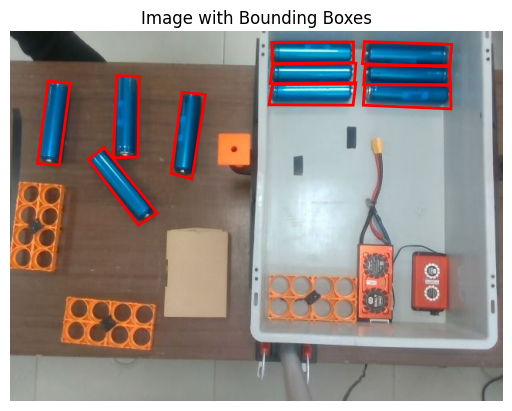

In [16]:
labels = args.annotations_dir +  args.img_name + '.txt'
print('Labels directory:', labels)

for tc in [0]:#[0,1,2,3,4,5,6,7]:
    bboxes, _ = load_and_convert_bboxes(labels,img_height=args.input_size[0],img_width=args.input_size[1], target_class= tc)
    plot_image_with_bboxes(img_np,bboxes)

### set the target class

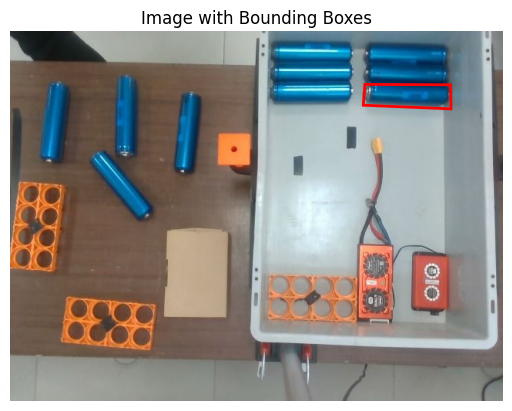

Target bbox: [(460.41984, 68.31984), (571.68, 68.84976), (572.20992, 100.11024), (458.30016, 95.34)]


In [17]:
target_class = args.target_classes[0] # select a single class (list is given)
target_bbox = bboxes[0] # select the first bbox --> multiple might be given in the same image
plot_image_with_bboxes(img_np,[target_bbox])
print('Target bbox:',target_bbox)

## YOLO
Load model and test to see its predictions

In [18]:
model = YOLO(args.model_path, task='detect')


0: 480x640 10 battery_individuals, 1 bms_a, 1 bms_b, 1 unknown_object, 3 battery_holders, 3.9ms
Speed: 0.0ms preprocess, 3.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


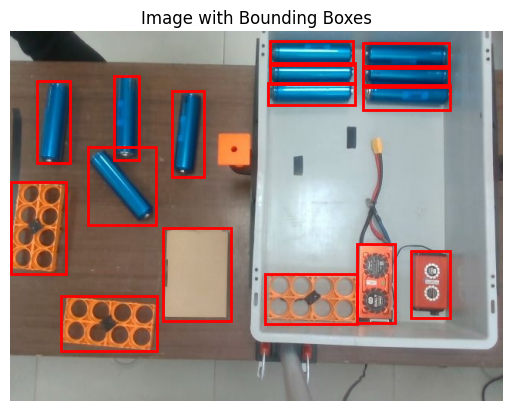

In [19]:
results=model.predict(tensor) 

boxes = results[0].boxes  # Assuming we have one image and accessing the first result
predicted_bboxes = []
for box in boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
    # Convert to a list of (x, y) tuples
    bbox = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
    predicted_bboxes.append(bbox)
# print(bboxes)
plot_image_with_bboxes(img_np, predicted_bboxes)

## D-CLOSE

### Generate masks

In [20]:
explainer = DRISEBatch(
    model=model, 
    input_size=args.input_size, 
    device=args.device,
    gpu_batch=args.gpu_batch
)

masks = {}
segment_levels = [50, 100, 200, 400, 800]
num_masks_per_level = int(args.N) // len(segment_levels)

for l in range(len(segment_levels)):
    mask = explainer.generate_masks_for_level(
        img_np=img_np,
        N = num_masks_per_level,
        p1 = args.p1,
        level_segments=segment_levels[l],
    )
    masks[segment_levels[l]] = mask

Generating masks for 50 segments: 100%|██████████| 200/200 [00:00<00:00, 290.92it/s]


Generated 200 masks for segmentation level 50 with shape: (200, 1, 480, 640)
Total time for 50 segments: 0.98 seconds (0 min 0.98 seconds)


Generating masks for 100 segments: 100%|██████████| 200/200 [00:01<00:00, 142.57it/s]


Generated 200 masks for segmentation level 100 with shape: (200, 1, 480, 640)
Total time for 100 segments: 1.68 seconds (0 min 1.68 seconds)


Generating masks for 200 segments: 100%|██████████| 200/200 [00:02<00:00, 74.62it/s]


Generated 200 masks for segmentation level 200 with shape: (200, 1, 480, 640)
Total time for 200 segments: 2.97 seconds (0 min 2.97 seconds)


Generating masks for 400 segments: 100%|██████████| 200/200 [00:05<00:00, 37.12it/s]


Generated 200 masks for segmentation level 400 with shape: (200, 1, 480, 640)
Total time for 400 segments: 5.69 seconds (0 min 5.69 seconds)


Generating masks for 800 segments: 100%|██████████| 200/200 [00:10<00:00, 18.81it/s]


Generated 200 masks for segmentation level 800 with shape: (200, 1, 480, 640)
Total time for 800 segments: 10.95 seconds (0 min 10.95 seconds)


## Apply XAI for all levels

In [21]:
saliency_maps = {}
for l in segment_levels:
    explainer.load_masks(masks[l])
    saliency = explainer(
        x=tensor,
        target_class_indices=[target_class], # assumes a list of targets
        target_bbox=target_bbox
    )
    saliency_maps[l] = saliency[target_class]

Loaded 200 masks directly


100%|██████████| 13/13 [00:01<00:00, 10.12it/s]


Loaded 200 masks directly


100%|██████████| 13/13 [00:01<00:00, 10.45it/s]


Loaded 200 masks directly


100%|██████████| 13/13 [00:01<00:00,  8.56it/s]


Loaded 200 masks directly


100%|██████████| 13/13 [00:01<00:00,  9.33it/s]


Loaded 200 masks directly


100%|██████████| 13/13 [00:01<00:00, 10.36it/s]


### Combine saliency maps

In [22]:
heatmap = np.zeros_like(saliency_maps[segment_levels[0]], dtype=np.float32)

for i,l in enumerate(reversed(segment_levels)):
    saliency = saliency_maps[l]
    
    # Check if the saliency map has no variation (all values are the same)
    if saliency.max() == saliency.min():
        saliency_normalized = np.zeros_like(saliency)  # Set to zero if no variation
    else:
        # use the density map of the mask to adjust the saliency map
        if isinstance(masks[l], torch.Tensor):
            density_map = np.sum(masks[l].squeeze().cpu().numpy() != 0, axis=(0))  # Convert to numpy array first
        else:
            density_map = np.sum(masks[l] != 0, axis=(0))  
        
        # Avoid division by zero: replace zeros in density_map with a small constant (1e-6) to prevent NaN values or extreme results
        density_map[density_map == 0] = 1
        saliency /= density_map
        
        # Normalize the saliency map for the current level
        saliency_normalized = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Add the (normalized) saliency map to the heatmap
    heatmap += saliency_normalized
    
    # If it's not the first level, multiply the heatmap with the current saliency map
    if i != 0:
        heatmap *= saliency_normalized

if heatmap.max() > 0:
    heatmap /= heatmap.max()
else:
    heatmap = np.zeros_like(heatmap)  # Set to zeros if max is zero to avoid NaN

### Plot heatmap/saliency map given by XAI

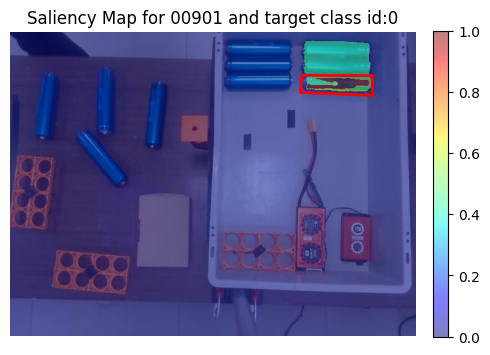

In [23]:
plot_saliency_and_targetbb_on_image(
        height=args.input_size[0], width=args.input_size[1], 
        img_name=args.img_name, 
        img=img_np,
        saliency_map=heatmap, 
        target_class_id= target_class,
        target_bbox=target_bbox
    )

## do the same for another target bbox

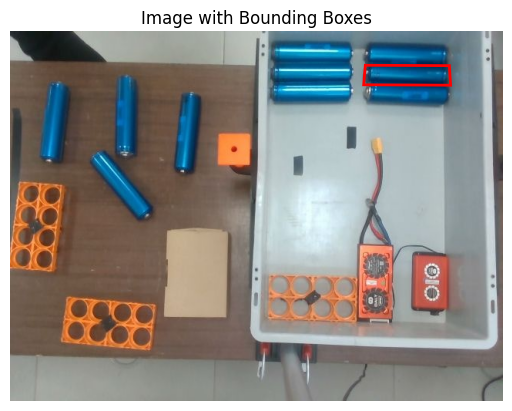

Target bbox: [(460.94976, 43.47), (570.09024, 43.95), (571.68, 69.38016), (458.83007999999995, 68.84976)]


In [24]:
bboxes, _ = load_and_convert_bboxes(labels,img_height=args.input_size[0],img_width=args.input_size[1], target_class= target_class)
target_bbox = bboxes[1] # select the first bbox --> multiple might be given in the same image
plot_image_with_bboxes(img_np,[target_bbox])
print('Target bbox:',target_bbox)

In [25]:
saliency_maps = {}
for l in segment_levels:
    explainer.load_masks(masks[l])
    saliency = explainer(
        x=tensor,
        target_class_indices=[target_class], # assumes a list of targets
        target_bbox=target_bbox
    )
    saliency_maps[l] = saliency[target_class]
    


heatmap = np.zeros_like(saliency_maps[segment_levels[0]], dtype=np.float32)

for i,l in enumerate(reversed(segment_levels)):
    saliency = saliency_maps[l]
    
    # Check if the saliency map has no variation (all values are the same)
    if saliency.max() == saliency.min():
        saliency_normalized = np.zeros_like(saliency)  # Set to zero if no variation
    else:
        # use the density map of the mask to adjust the saliency map
        if isinstance(masks[l], torch.Tensor):
            density_map = np.sum(masks[l].squeeze().cpu().numpy() != 0, axis=(0))  # Convert to numpy array first
        else:
            density_map = np.sum(masks[l] != 0, axis=(0))  
        
        # Avoid division by zero: replace zeros in density_map with a small constant (1e-6) to prevent NaN values or extreme results
        density_map[density_map == 0] = 1
        saliency /= density_map
        
        # Normalize the saliency map for the current level
        saliency_normalized = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Add the (normalized) saliency map to the heatmap
    heatmap += saliency_normalized
    
    # If it's not the first level, multiply the heatmap with the current saliency map
    if i != 0:
        heatmap *= saliency_normalized

if heatmap.max() > 0:
    heatmap /= heatmap.max()
else:
    heatmap = np.zeros_like(heatmap)  # Set to zeros if max is zero to avoid NaN

Loaded 200 masks directly


100%|██████████| 13/13 [00:01<00:00, 10.50it/s]


Loaded 200 masks directly


100%|██████████| 13/13 [00:01<00:00, 10.30it/s]


Loaded 200 masks directly


100%|██████████| 13/13 [00:01<00:00,  8.74it/s]


Loaded 200 masks directly


100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


Loaded 200 masks directly


100%|██████████| 13/13 [00:01<00:00, 10.20it/s]


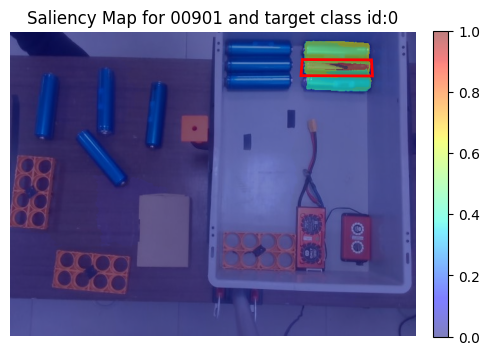

In [26]:
plot_saliency_and_targetbb_on_image(
        height=args.input_size[0], width=args.input_size[1], 
        img_name=args.img_name, 
        img=img_np,
        saliency_map=heatmap, 
        target_class_id= target_class,
        target_bbox=target_bbox
    )